### Sampling - Baseline : Statistical Features + GRU

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Virtual Metrology Model (statistical features)

In [8]:
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis, skew

In [9]:
# add the latest MRR column
def get_orig_data(dataset):
    
    train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0).reset_index(drop=True)
    test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0).reset_index(drop=True)

    short_sampled_orig = train_orig.iloc[316*2:, :].reset_index(drop=True)
    latest_mrr_sampled = train_orig.iloc[:-316*2, -1].rename('latest_mrr').reset_index(drop=True)
    addmrr_sampled_orig = pd.concat([short_sampled_orig, latest_mrr_sampled], axis=1)

    short_unsampled_orig = train_orig.iloc[316*1:, :].reset_index(drop=True)
    latest_mrr_unsampled = train_orig.iloc[:-316*1, -1].rename('latest_mrr').reset_index(drop=True)
    addmrr_unsampled_orig = pd.concat([short_unsampled_orig, latest_mrr_unsampled], axis=1)

    latest_mrr_test = pd.concat([train_orig.iloc[-316*1:, -1], test_orig.iloc[:-316*1, -1]], ignore_index=True).rename("latest_mrr").reset_index(drop=True)
    addmrr_test_orig = pd.concat([test_orig, latest_mrr_test], axis=1)
    
    return addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig

# transfer into the input data
def get_stats_features(data):
    orig_X = data.iloc[:, :-2].to_numpy()
    orig_X = orig_X.reshape(-1, 316, orig_X.shape[1])
    orig_y = data.iloc[:, -2].tolist()
    data_y = [orig_y[i] for i in range(0, len(orig_y), 316)]
    # create the latest MRR for every samples
    latest_mrr = data.iloc[:, -1].tolist()
    latest_mrr = [latest_mrr[i] for i in range(0, len(latest_mrr), 316)]
    
    # calculate the statistics features
    means = np.mean(orig_X, axis=1)
    stds = np.std(orig_X, axis=1)
    medians = np.median(orig_X, axis=1)
    mins = np.min(orig_X, axis=1)
    maxs = np.max(orig_X, axis=1)
    kurts = kurtosis(orig_X, axis=1)
    skews = skew(orig_X, axis=1)
    stats_X = np.hstack([means, stds, medians, mins, maxs, kurts, skews])
    stats_X = np.nan_to_num(stats_X, nan=0.0)

    # add the latest MRR
    latest_mrr = np.array(latest_mrr).reshape(-1,1)
    data_X = np.concatenate((stats_X, latest_mrr), axis=1)

    return data_X, data_y

# fit different ML models
def fit_XGB(X_train, y_train):
    import xgboost as xgb
    params = {
        'objective': 'reg:squarederror',  # 回歸問題
        'max_depth': 3,                    # 樹的最大深度
        'learning_rate': 0.01,              # 學習率
        'n_estimators': 200                # 樹的數量
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

def fit_RF(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)
    return model

def fit_KNN(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def fit_MLP(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(128, 16), activation='relu', solver='adam', max_iter=2000, random_state=2)
    model.fit(X_train, y_train)
    return model

# generate the VM MRR prediction
def get_VM_predition(dataset, mode_type):  # model_type: 'XGB'/'RF'/'KNN'/"MLP"
    
    addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig = get_orig_data(dataset)
    
    # retain only sampled section for training
    sampled_train_orig = pd.concat([addmrr_sampled_orig.iloc[i:i+316] for i in range(0, len(addmrr_sampled_orig), 316*2)], ignore_index=True)
    unsampled_train_orig = pd.concat([addmrr_unsampled_orig.iloc[i:i+316] for i in range(316, len(addmrr_unsampled_orig), 316*2)], ignore_index=True)
    all_test_orig = pd.concat([unsampled_train_orig, addmrr_test_orig], ignore_index=True)
    extend_test_orig = pd.concat([addmrr_unsampled_orig.iloc[-316*4:], addmrr_test_orig], ignore_index=True)

    y_pred = {}
    X_train, y_train = get_stats_features(sampled_train_orig)
    # unsampled : unsampled wafer in training set / test : testing set / all : 'unsampled and test' / extend : 'testing set extended to past wafers'(for equipment state model)
    data_modes = {'unsampled':unsampled_train_orig, 'test':addmrr_test_orig, 'all':all_test_orig, 'extend':extend_test_orig}
    for mode, data in data_modes.items():
        match mode_type:
            case 'XGB':
                model = fit_XGB(X_train, y_train)
            case 'RF':
                model = fit_RF(X_train, y_train)
            case 'KNN':
                model = fit_KNN(X_train, y_train)
            case 'MLP':
                model = fit_MLP(X_train, y_train)

        X_test, y_test = get_stats_features(data)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)

        print('------------------------------------------------')
        print(mode)
        print(f"Statistical Features + {mode_type} VM test loss", round(mse, 3))
        y_pred[mode] = model.predict(X_test)

    return y_pred

#### Statistical Features + GRU Model

In [10]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

import random

import sys
from datetime import datetime

In [11]:
# check GPU setting
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090 Ti


In [12]:
# function to set random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
     torch.manual_seed(seed)
     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [13]:
# function to calculate statistical features
def get_stats_data(data, lenth=316):
    slices = torch.split(data, lenth, dim=0)
    all_stat = []
    for slice in slices:
        means = torch.mean(slice, dim=0)
        stds = torch.std(slice, dim=0)
        medians = torch.median(slice, dim=0).values
        mins = torch.min(slice, dim=0).values
        maxs = torch.max(slice, dim=0).values
        kurts = torch.from_numpy(kurtosis(slice.numpy(), axis=0))
        skews = torch.from_numpy(skew(slice.numpy(), axis=0))
        stats = torch.cat([means, stds, medians, mins, maxs, skews, kurts])
        all_stat.append(stats)
    all_stat = torch.stack(all_stat)
    all_stat = torch.nan_to_num(all_stat, nan=0.0)

    return all_stat

In [14]:
# transfer the raw data to the Dataset class
class myDataset(Dataset):
    def __init__(self, raw_data, past_wafer, vm_pred, mode='train'):
        self.raw_data = raw_data
        self.vm_pred = vm_pred

        x_data = np.array(raw_data)[:, :-1]
        labels = np.array(raw_data)[:, -1]

        data = x_data
        data = torch.tensor(data).double()
        labels = torch.tensor(labels).double()

        x_arr, y_arr, mrr_arr = [], [], []
        total_time_len, node_num,  = data.shape
        wafer_len = 316
        past_win = 316 * past_wafer
        
        # sampling setting
        mrr_all = torch.unique_consecutive(labels)

        if mode == 'train':
            rang1 = range(316 + 316 * 2, total_time_len - past_win + 316, 316 * 2)
            rang2 = range(past_win + 316 * 2, total_time_len, 316 * 2)
            mrr_all = mrr_all[2:]  # for add former MRR
            mrr_sampling = torch.tensor([mrr_all[i] if i % 2 == 0 else self.vm_pred[int(i / 2)] for i in range(len(mrr_all))])

        else:
            rang1 = range(316, total_time_len - past_win + 316, 316)
            rang2 = range(past_win, total_time_len, 316)
            mrr_sampling = torch.tensor([mrr_all[i] if i % 2 == 0 else self.vm_pred[i] for i in range(len(mrr_all))])

        for i in rang1:
            ft = data[i-316:i, :]
            stats = get_stats_data(ft)
            x_arr.append(stats)
        
        for i in rang2:
            y_arr.append(labels[i])
           
            mrr = mrr_sampling[int(i / 316) - past_wafer:int(i / 316)]  # retain only one MRR for a wafer
            mrr_arr.append(mrr)
        
        self.x = torch.stack(x_arr).contiguous()
        self.y = torch.stack(y_arr).contiguous()
        self.z = torch.stack(mrr_arr).contiguous()
        self.len = len(x_arr)

    def __getitem__(self, idx):

        x = self.x[idx].double()
        y = self.y[idx].double()
        z = self.z[idx].double()

        return x, y, z
    
    def __len__(self):
        return self.len

In [15]:
# model buliding
class Stats_GRU(nn.Module):
    def __init__(self, input_dim, inter_dim, layer_num, past_wafer):
        super(Stats_GRU, self).__init__()
        self.inter_dim = inter_dim
        self.layer_num = layer_num

        self.bn = nn.BatchNorm1d(input_dim)

        # define GRU layer
        self.gru = nn.GRU(input_dim, inter_dim, layer_num, batch_first=True)

        # define MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(inter_dim+past_wafer, 1),
            nn.ReLU())

    def forward(self, x, mrr):
        # initialize original memory
        h0 = torch.zeros(self.layer_num, x.size(0), self.inter_dim).double().to(x.device)

        # forward propagation，x size (batch_size, sequence_length, input_dim)
        out, _ = self.gru(x, h0)

        # retain the last memory
        out = out[:, -1, :]

        # concat past MRR
        out = torch.hstack((out, mrr))

        # go through MLP layer
        out = self.mlp(out)

        return out.squeeze(1)

In [16]:
# split out the validation set and transfer into dataloaders
def get_loaders(train_dataset, seed, batch_size, val_ratio=0.1):
    dataset_len = int(len(train_dataset))
    train_use_len = int(dataset_len * (1 - val_ratio))
    val_use_len = int(dataset_len * val_ratio)
    val_start_index = random.randrange(train_use_len)
    indices = torch.arange(dataset_len)

    train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
    train_subset = Subset(train_dataset, train_sub_indices)

    val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
    val_subset = Subset(train_dataset, val_sub_indices)

    train_dataloader = DataLoader(train_subset, batch_size,
                            shuffle=False)

    val_dataloader = DataLoader(val_subset, batch_size,
                            shuffle=False)

    return train_dataloader, val_dataloader

In [17]:
def test(model, test_dataloader, device):
    
    model.eval()

    test_pred_list = []
    test_ground_list = []
    loss_list = []

    for x, y, z in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)

        with torch.no_grad():

            model = model.double()
            out = model(x, z).to(device)
            loss = F.mse_loss(out, y, reduction='mean')
            
            test_pred_list.extend(out.detach().cpu().tolist())
            test_ground_list.extend(y.detach().cpu().tolist())
            
        loss_list.append(loss.detach().cpu().item())
    
    avg_loss = sum(loss_list)/len(loss_list)

    return avg_loss, [test_pred_list, test_ground_list] 

In [18]:
def train(model, train_dataloader, val_dataloader, optimizer, epoch, device, path):
    
    min_loss = 1e+8
    early_stop_win = 30

    for i_epoch in range(epoch):

        loss_list= []
        acu_loss = 0
        model.train()

        for x, y, z in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            
            optimizer.zero_grad()
            model = model.double()
            out = model(x, z).to(device)
            loss = F.mse_loss(out, y, reduction='mean')
            
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.item())
            acu_loss += loss.item()

        val_loss, _ = test(model, val_dataloader, 'cuda')

        if val_dataloader is not None:

            val_loss, val_result = test(model, val_dataloader, 'cuda')

            if val_loss < min_loss:
                torch.save(model.state_dict(), path)

                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1

            if stop_improve_count >= early_stop_win:
                break

        else:
            if acu_loss < min_loss:
                torch.save(model.state_dict(), path)
                min_loss = acu_loss

        # each epoch
        print(
            'epoch ({} / {}) (Train_loss:{:.8f}, ACU_loss:{:.8f}, Val_loss:{:.8f})'
            .format(
                i_epoch + 1,
                epoch,
                acu_loss / len(train_dataloader),
                acu_loss,
                val_loss,
            ),
            flush=True)

A456

In [19]:
# training setting
dataset = 'A456'
batch_size = 256
input_dim = 19 * 7
inter_dim = 64
layer_num = 3
past_wafer = 4
val_ratio = 0.2
seed = 2

# set random seed
setup_seed(seed)

In [20]:
# get VM MRR prediction
vm_pred = get_VM_predition(dataset,'RF')
y_pred_train = vm_pred['unsampled']
y_pred_test = vm_pred['extend']

------------------------------------------------
unsampled
Statistical Features + RF VM test loss 4.381
------------------------------------------------
test
Statistical Features + RF VM test loss 12.192
------------------------------------------------
all
Statistical Features + RF VM test loss 7.993
------------------------------------------------
extend
Statistical Features + RF VM test loss 12.179


In [21]:
# get training and testing dataset
train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
# concat the past wafer referenced from training set
test_extend = pd.concat((train_orig.iloc[-(316 * past_wafer):,:], test_orig))

train_dataset = myDataset(train_orig, past_wafer, y_pred_train, mode='train')
test_dataset = myDataset(test_extend, past_wafer, y_pred_test, mode='test')
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = Stats_GRU(input_dim, inter_dim, layer_num, past_wafer).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/Stats_GRU/best_{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

epoch (1 / 2000) (Train_loss:3283.38782768, ACU_loss:6566.77565535, Val_loss:3090.73563355)
epoch (2 / 2000) (Train_loss:3208.41184130, ACU_loss:6416.82368259, Val_loss:3019.04580942)
epoch (3 / 2000) (Train_loss:3133.74205538, ACU_loss:6267.48411076, Val_loss:2947.13277117)
epoch (4 / 2000) (Train_loss:3058.73458865, ACU_loss:6117.46917729, Val_loss:2874.56176977)
epoch (5 / 2000) (Train_loss:2983.00065434, ACU_loss:5966.00130869, Val_loss:2800.95904765)
epoch (6 / 2000) (Train_loss:2906.17164371, ACU_loss:5812.34328742, Val_loss:2725.91051460)
epoch (7 / 2000) (Train_loss:2827.87533774, ACU_loss:5655.75067547, Val_loss:2649.18785538)
epoch (8 / 2000) (Train_loss:2747.96990157, ACU_loss:5495.93980315, Val_loss:2570.74750010)
epoch (9 / 2000) (Train_loss:2666.42641254, ACU_loss:5332.85282507, Val_loss:2490.66420130)
epoch (10 / 2000) (Train_loss:2583.30176333, ACU_loss:5166.60352665, Val_loss:2409.13771410)
epoch (11 / 2000) (Train_loss:2498.80473263, ACU_loss:4997.60946525, Val_loss:2

MSE :  9.635653674994906


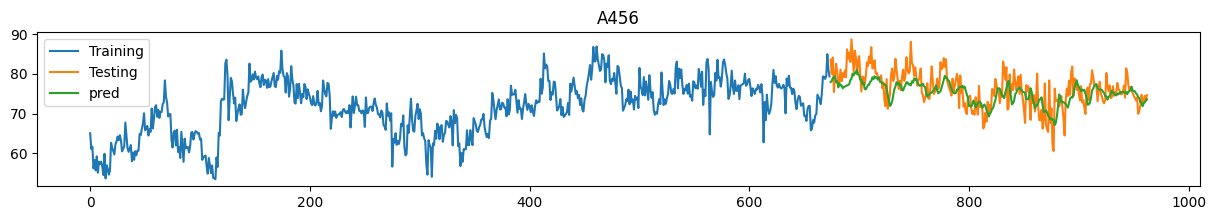

In [70]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', avg_loss)

# plot the result
y_train = [train_orig['MRR'][i] for i in range(0, len(train_orig), 316)]
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Training')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Testing')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()

B456

In [12]:
# training setting
dataset = 'B456'
batch_size = 256
input_dim = 19 * 7
inter_dim = 8
layer_num = 2
past_wafer = 4
val_ratio = 0.2
seed = 2

# set random seed
setup_seed(seed)

In [13]:
# get VM MRR prediction
vm_pred = get_VM_predition(dataset,'RF')
y_pred_train = vm_pred['unsampled']
y_pred_test = vm_pred['extend']

------------------------------------------------
unsampled
pretain GDN-RF VM test loss 5.976
------------------------------------------------
test
pretain GDN-RF VM test loss 17.214
------------------------------------------------
all
pretain GDN-RF VM test loss 11.18
------------------------------------------------
extend
pretain GDN-RF VM test loss 17.186


In [ ]:
# get training and testing dataset
train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
# concat the past wafer referenced from training set
test_extend = pd.concat((train_orig.iloc[-(316 * past_wafer):,:], test_orig))

train_dataset = myDataset(train_orig, past_wafer, y_pred_train, mode='train')
test_dataset = myDataset(test_extend, past_wafer, y_pred_test, mode='test')
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = Stats_GRU(input_dim, inter_dim, layer_num, past_wafer).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/Stats_GRU/best_{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

epoch (1 / 2000) (Train_loss:1444.60255330, ACU_loss:2889.20510661, Val_loss:1404.27286359)
epoch (2 / 2000) (Train_loss:1396.59304738, ACU_loss:2793.18609475, Val_loss:1357.49951634)
epoch (3 / 2000) (Train_loss:1349.50765140, ACU_loss:2699.01530280, Val_loss:1311.62209274)
epoch (4 / 2000) (Train_loss:1303.34836782, ACU_loss:2606.69673564, Val_loss:1266.65545842)
epoch (5 / 2000) (Train_loss:1258.12080661, ACU_loss:2516.24161322, Val_loss:1222.61525940)
epoch (6 / 2000) (Train_loss:1213.83384311, ACU_loss:2427.66768622, Val_loss:1179.51709168)
epoch (7 / 2000) (Train_loss:1170.49883740, ACU_loss:2340.99767479, Val_loss:1137.37498928)
epoch (8 / 2000) (Train_loss:1128.12795331, ACU_loss:2256.25590661, Val_loss:1096.20029395)
epoch (9 / 2000) (Train_loss:1086.73323042, ACU_loss:2173.46646084, Val_loss:1056.00150325)
epoch (10 / 2000) (Train_loss:1046.32565457, ACU_loss:2092.65130914, Val_loss:1016.78475984)
epoch (11 / 2000) (Train_loss:1006.91386037, ACU_loss:2013.82772075, Val_loss:9

MSE :  16.701326558143357


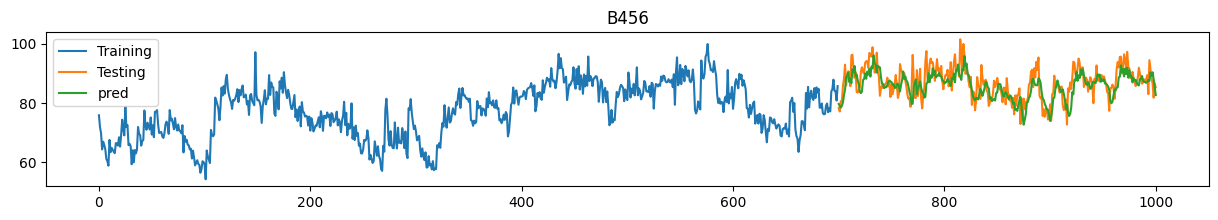

In [18]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', avg_loss)

# plot the result
y_train = [train_orig['MRR'][i] for i in range(0, len(train_orig), 316)]
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Training')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Testing')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()